In [156]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [157]:
df = pd.read_excel('premiums_young.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


### Data cleaning and EDA:

In [158]:
df.shape

(20096, 13)

In [159]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

##### Correcting the Header Structure

In [160]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


##### Handing NA values

In [161]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [162]:
df.dropna(inplace = True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

##### Checking for duplicate

In [163]:
df.duplicated().sum()
df.drop_duplicates(inplace= True)
df.duplicated().sum()

np.int64(0)

In [164]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


##### Handing the outlier for number_of_dependants column

In [165]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

##### Let's convert the negative numbers to positive.

In [166]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

##### Checking outliers in the numeric columns

In [167]:
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

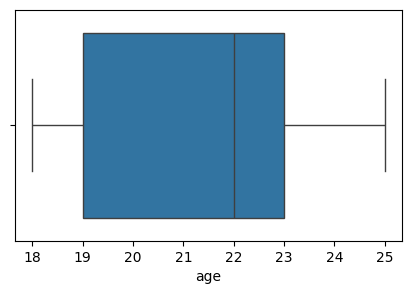

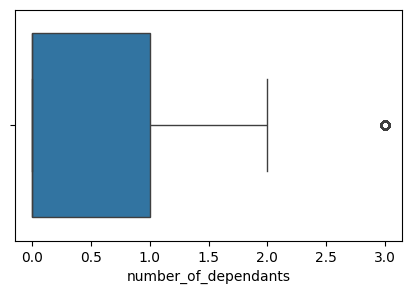

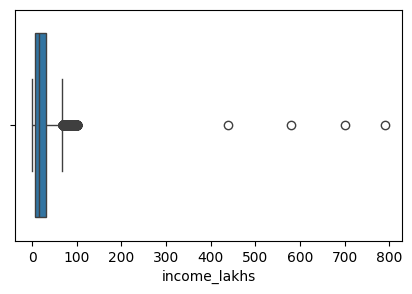

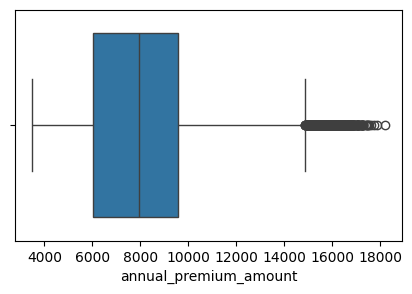

In [168]:
for col in numeric_columns:
    plt.figure(figsize=(5,3))
    sns.boxplot(x = df[col])
    plt.show()

In [169]:
df[df.age>100]['age'].unique()

array([], dtype=int64)

In [170]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

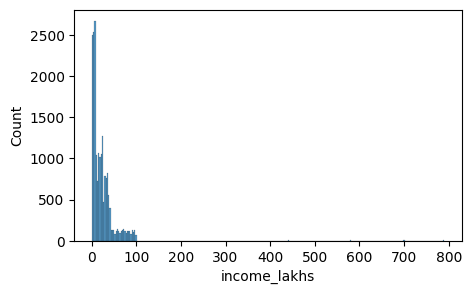

In [171]:
plt.figure(figsize=(5,3))
sns.histplot(df1.income_lakhs)

##### Lets use IQR(InterQuertile Range) method to treat outlier in the income_lakhs column

In [172]:
df1.income_lakhs.quantile([0.25,0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [173]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [174]:
df1[df1.income_lakhs > quantile_threshold].shape ### As there as no many records we can drop them.

(4, 13)

In [175]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


##### Lets analyse the disribution of the numeric data columns in our datset:

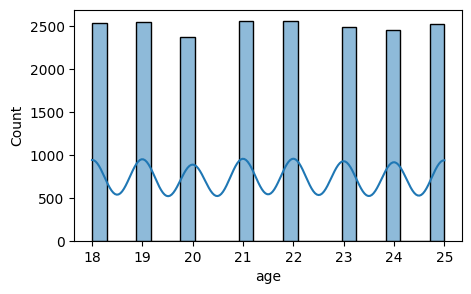

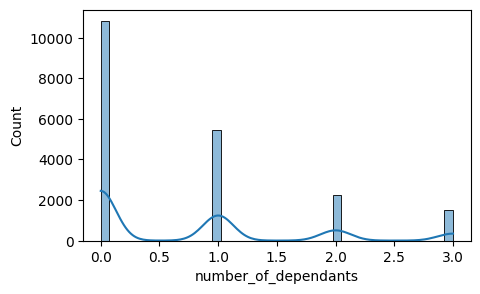

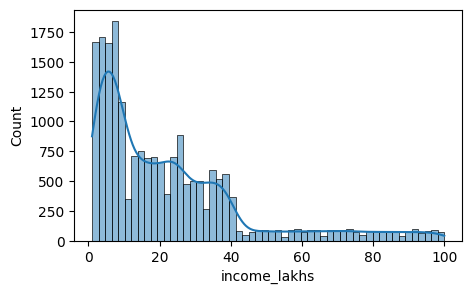

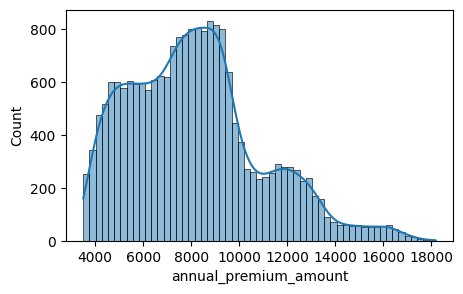

In [176]:
for col in numeric_columns:
    plt.figure(figsize=(5,3))
    sns.histplot(df2[col],kde = True)
    plt.show()

##### We can make the visuals like this also.

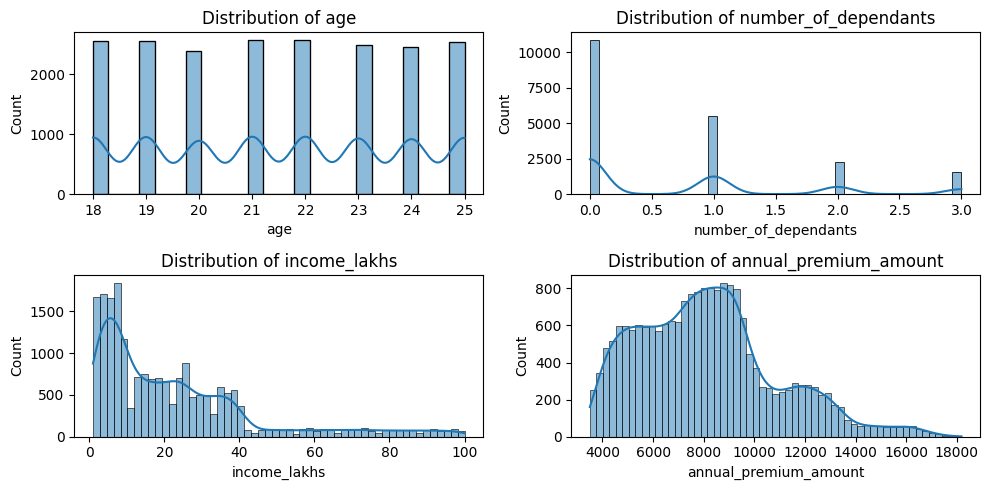

In [177]:
cols_to_plot = numeric_columns[:4]
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# Flatten axes array for easy indexing
axs = axs.flatten()

# Plot each histogram
for i, col in enumerate(cols_to_plot):
    sns.histplot(df2[col], kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

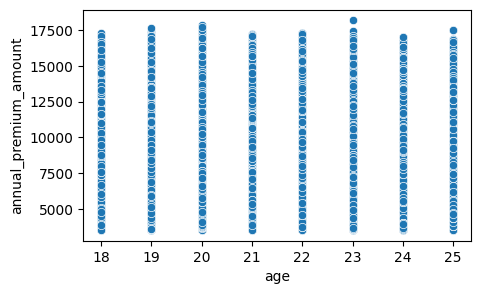

In [178]:
plt.figure(figsize=(5,3))
sns.scatterplot(df2, x='age' , y= 'annual_premium_amount')
plt.show()

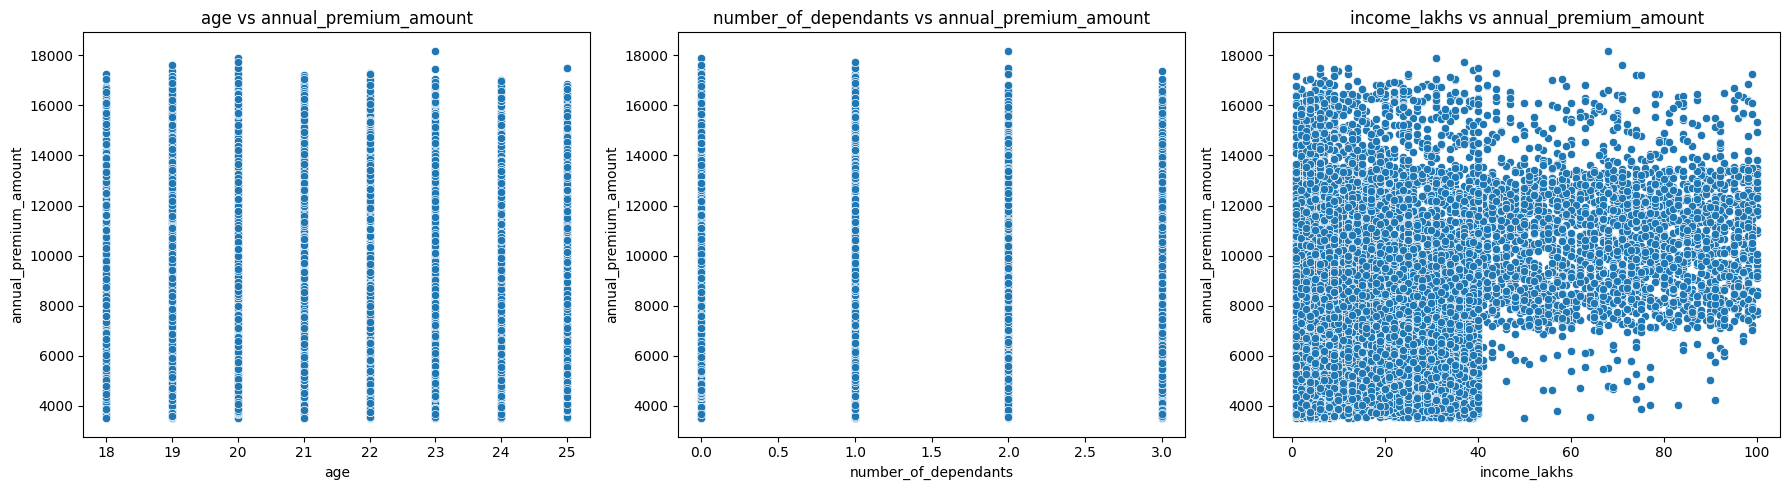

In [179]:
independent_vars = ['age', 'number_of_dependants', 'income_lakhs']
dependent_var = 'annual_premium_amount'

# Create 1 row with 3 scatterplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Loop through independent variables and plot
for i, col in enumerate(independent_vars):
    sns.scatterplot(data=df2, x=col, y=dependent_var, ax=axs[i])
    axs[i].set_title(f'{col} vs {dependent_var}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel(dependent_var)

# Adjust layout
plt.tight_layout()
plt.show()

##### Now Let's Analyse the Categorical columns:

In [180]:
df2.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [181]:
categorical_columns = df2.select_dtypes(include='object').columns.tolist()
print(categorical_columns)

['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']


In [182]:
for col in categorical_columns:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [183]:
df2['smoking_status']= df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke' :'No Smoking',
    'Not Smoking': 'No Smoking'
})
df2.smoking_status.unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [184]:
df2.gender.value_counts()

gender
Male      11055
Female     9031
Name: count, dtype: int64

In [185]:
pct_count= df2.gender.value_counts(normalize=True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

In [186]:
pct_count.values

array([0.55038335, 0.44961665])

In [187]:
pct_count.index

Index(['Male', 'Female'], dtype='object', name='gender')

<Axes: xlabel='gender'>

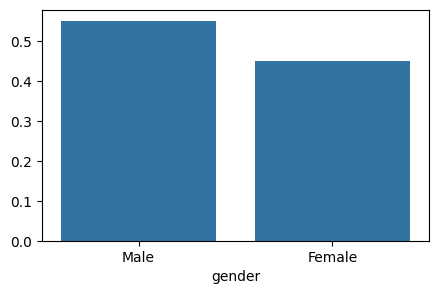

In [188]:
plt.figure(figsize=(5,3))
sns.barplot(x=pct_count.index, y=pct_count.values)

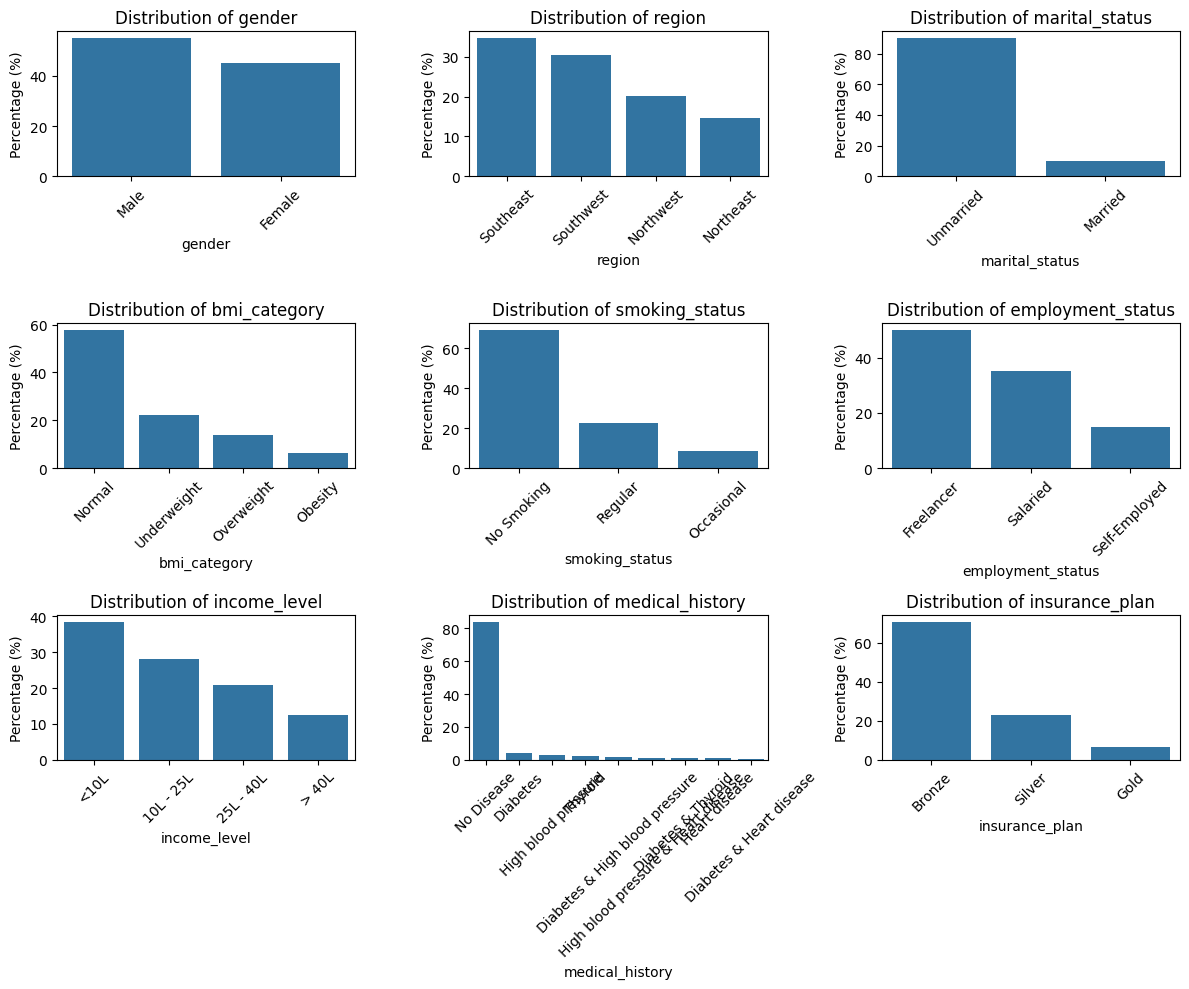

In [189]:
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
axs = axs.flatten()  # Flatten to 1D for easy indexing

# Plot each categorical column
for i, col in enumerate(categorical_columns):
    pct_count = df2[col].value_counts(normalize=True) * 100  # percentage
    sns.barplot(x=pct_count.index, y=pct_count.values, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_ylabel('Percentage (%)')
    axs[i].set_xlabel(col)
    axs[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots (in case fewer than 9 columns)
for j in range(len(categorical_columns), len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

##### In terms of Bivariate analysis If i wanna know the relation between two categorical columns i can use crosstab function of pandas

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


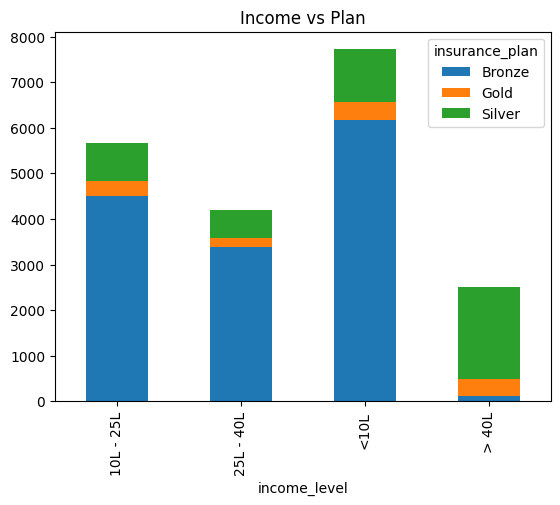

In [190]:
crosstab = pd.crosstab(df2['income_level'],df2['insurance_plan'])
print(crosstab)
crosstab.plot(kind='bar',stacked = True)
plt.title('Income vs Plan')
plt.show()

##### We can also use heatmap for visualize this as:

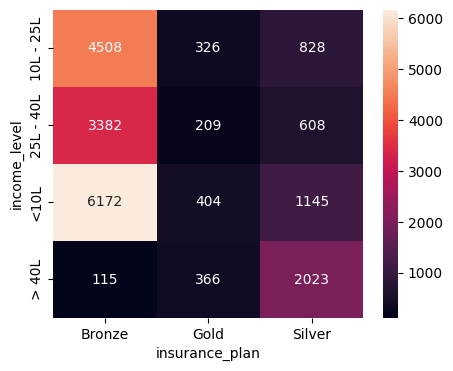

In [191]:
plt.figure(figsize=(5,4))
sns.heatmap(crosstab, annot= True, fmt= 'd')
plt.show()

### Feature Engineering

In [192]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


In [193]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [194]:
risk_scores= {
    'diabetes':6,
    'heart disease':8,
    'high blood pressure': 6,
    'thyroid':5,
    'no disease': 0,
    'none':0
}

df2[['disease1','disease2']] = df2['medical_history'].str.split(" & ", expand= True).apply(lambda x: x.str.lower())
df2.sample(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
6486,25,Male,Southeast,Unmarried,0,Underweight,Regular,Freelancer,10L - 25L,12,No Disease,Silver,9356,no disease,None
6658,22,Male,Southwest,Unmarried,1,Normal,No Smoking,Freelancer,<10L,8,No Disease,Bronze,8952,no disease,None
12696,25,Female,Southeast,Unmarried,0,Normal,No Smoking,Salaried,<10L,7,No Disease,Bronze,7716,no disease,None


In [195]:
#df2['disease1'].fillna('none',inplace =True)
#df2['disease2'].fillna('none',inplace =True)

df2.fillna({'disease1':'none','disease2':'none'}, inplace = True)
df2.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
disease1                 0
disease2                 0
dtype: int64

In [196]:
df2['total_risk_score'] = 0

for disease in ['disease1','disease2']:
    df2['total_risk_score'] +=  df2[disease].map(risk_scores) 

### Normalize the total_risk_column here only:
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


##### Label Encoding for the Ordinal Columns

In [197]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [198]:
#### Let'sdo label encoding for insurance_plan column:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})
df2.insurance_plan.unique()

array([2, 1, 3])

In [199]:
#### Doing same for income_label:

df2.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [200]:
df2['income_level'] = df2['income_level'].map({
    '<10L': 1,
    '10L - 25L': 2,
    '25L - 40L': 3,
    '> 40L': 4
})
df2['income_level'].unique()

array([4, 1, 2, 3])

In [201]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,no disease,none,0,0.000000


##### One Hot Encoding for the Nominal Columns

In [202]:
nominal_cols = ['gender', 'region','marital_status','bmi_category','smoking_status','employment_status']
df3 = pd.get_dummies(df2, columns= nominal_cols, drop_first=True, dtype=int)

In [203]:
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0


In [204]:
df3.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'medical_history', 'insurance_plan', 'annual_premium_amount',
       'disease1', 'disease2', 'total_risk_score', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [205]:
df4 = df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


##### Plotting the correlation Matrix:

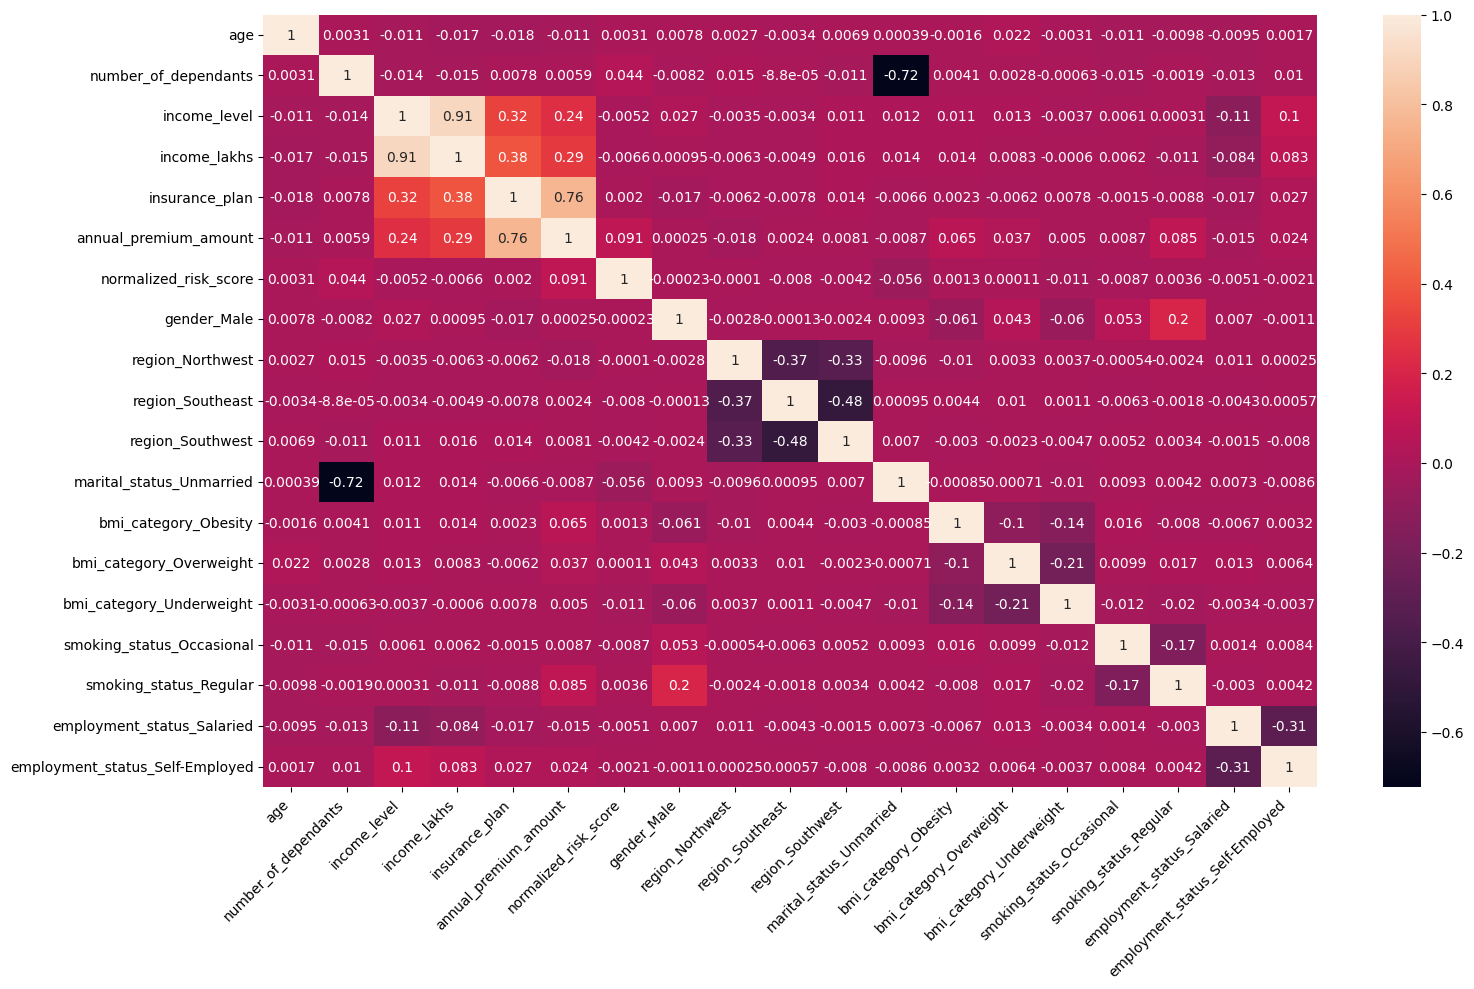

In [206]:
cm = df4.corr()

plt.figure(figsize=(16,10))
sns.heatmap(cm,annot= True)
plt.xticks(rotation =45, ha='right')
plt.yticks(rotation =0)
plt.tight_layout()
plt.show()

##### We can select the features for our model using this correlation matrix but VIF is a better solution for feature selection:

In [207]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


In [208]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

### Let's do scaling
from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,1.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.333333,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.333333,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


In [209]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
   vif_df = pd.DataFrame()
   vif_df['Feature'] = data.columns
   vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
   return vif_df

In [210]:
calculate_vif(X)

,Feature,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


In [211]:
calculate_vif(X.drop('income_level', axis='columns'))

,Feature,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [212]:
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head(10)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0
5,0.571429,0.000000,0.292929,1.0,0.428571,0,0,0,1,1,0,0,1,0,1,0,0
6,0.142857,0.000000,0.070707,0.0,0.000000,1,0,0,1,1,0,0,0,0,0,0,0
7,0.000000,0.333333,0.040404,0.0,0.857143,0,1,0,0,1,0,0,1,0,0,1,0
8,0.714286,0.000000,0.070707,0.0,0.000000,1,1,0,0,1,0,0,1,0,0,1,0
9,0.285714,0.000000,0.171717,0.0,0.000000,0,0,0,0,1,0,0,0,1,0,1,0


#### Model Training:

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state= 10)

print('x_train:', X_train.shape)
print('x_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

x_train: (14060, 17)
x_test: (6026, 17)
y_train: (14060,)
y_test: (6026,)


In [214]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.6020471274164894, 0.6047589163893645)

In [215]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ===> MSE: ",mse_lr,"RMSE: ",rmse_lr)

Linear Regression ===> MSE:  3005669.8791236714 RMSE:  1733.6867880686152


In [216]:
model_lr.intercept_

np.float64(6614.583391230751)

In [217]:
model_lr.coef_

array([ 5.51905147e+01, -1.45039643e+02, -3.60667677e+01,  7.00007042e+03,
        1.11127879e+03,  9.82564766e+00, -1.14273450e+02, -3.64663714e+01,
       -6.72232248e+01, -5.85343424e+01,  7.92952660e+02,  4.35760406e+02,
        1.69728916e+02,  2.44813937e+02,  6.19082947e+02, -1.30535485e+01,
       -4.34272200e+00])

##### We can show this coefficients in a horizontal bar chart to visualize how much it contributes to the final prediction.

In [218]:
X_test.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12774,1.000000,0.666667,0.040404,0.0,0.0,1,0,0,1,1,0,0,1,0,0,0,0
14758,0.285714,0.000000,0.060606,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,1


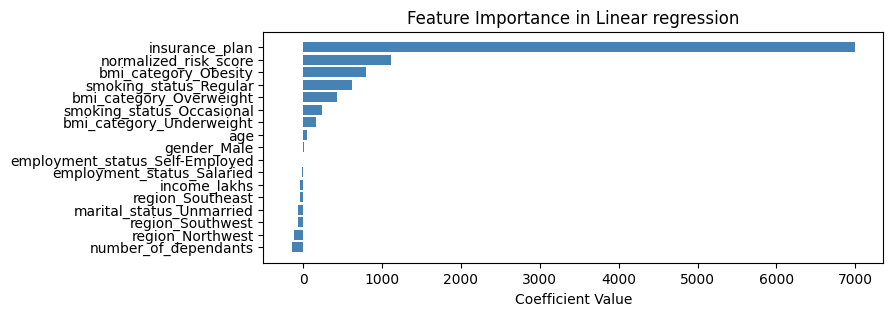

In [219]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index= X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by= 'Coefficients', ascending = True)


plt.figure(figsize =(8,3))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear regression')
plt.show()

##### Checking Score with Ridge() Model

In [220]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.6020466631305188, 0.6047715291063815)

##### Going with XGBoost

In [221]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.7251046895980835, 0.5638787746429443)

In [222]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBRegressor ===> MSE: ",mse_xgb,"RMSE: ",rmse_xgb)

XGBRegressor ===> MSE:  3316549.0 RMSE:  1821.1394784584731


##### Using RandomizedSearchCV for hyperparameter tuning:

In [223]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators':[20,40,50],
    'learning_rate':[0.01, 0.1, 0.2],
    'max_depth':[3,4,5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42)
random_search.fit(X_train,y_train)
print(random_search.best_score_)
print(random_search.best_params_)

0.5997088948885599
{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}


In [224]:
best_model = model_lr
best_model

LinearRegression()

### Error Analysis:

In [225]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

result_df= pd.DataFrame({
    'actuals': y_test,
    'predicted':y_pred,
    'diff': residuals,
    'diff_pct':residuals_pct
})
result_df.head()

,actuals,predicted,diff,diff_pct
12774,6238,6625.420564,387.420564,6.210653
14758,9462,7117.148903,-2344.851097,-24.781770
13205,5152,7052.316369,1900.316369,36.885023
14278,6988,7924.504344,936.504344,13.401608
19351,4917,6696.274716,1779.274716,36.186185


<Axes: xlabel='diff_pct', ylabel='Count'>

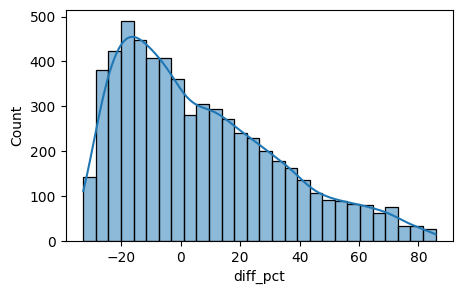

In [226]:
plt.figure(figsize=(5,3))
sns.histplot(result_df['diff_pct'], kde = True)

##### We have decided that the maximum error should be less than 10%.

In [227]:
extreme_error_threshold = 10
extreme_results_df = result_df[np.abs(result_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(4404, 4)

In [228]:
result_df.shape

(6026, 4)

In [229]:
#### Finding the percentage of extreme errors:

extreme_error_pct = extreme_results_df.shape[0]*100/result_df.shape[0]
extreme_error_pct

73.08330567540658

##### Now I want to find where exactly is the problem:

In [230]:
extreme_results_df.index

Index([14758, 13205, 14278, 19351, 10622, 14799, 16348,  5573,  5634, 14882,
       ...
       10266,  5484,  8988,  9658,  1365,   399, 17652,  5807, 10298, 13316],
      dtype='int64', length=4404)

In [231]:
X_test.index

Index([12774, 14758, 13205, 14278, 19351, 10622, 16391, 14799, 17184, 16348,
       ...
        8695,  9658, 14195,  1365,   399, 17652,  5807, 10298, 13316,  2583],
      dtype='int64', length=6026)

In [232]:
extreme_errors_df = X_test.loc[extreme_results_df.index] ### SO these are the rows that have high margin errors.
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
10622,0.428571,0.333333,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0


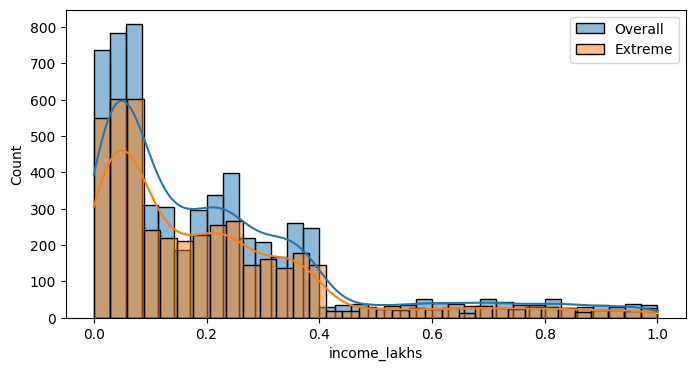

In [233]:
plt.figure(figsize=(8, 4))
sns.histplot(X_test.income_lakhs, label="Overall", kde = True)
sns.histplot(extreme_errors_df.income_lakhs, label="Extreme", kde = True)
plt.legend()
plt.show()

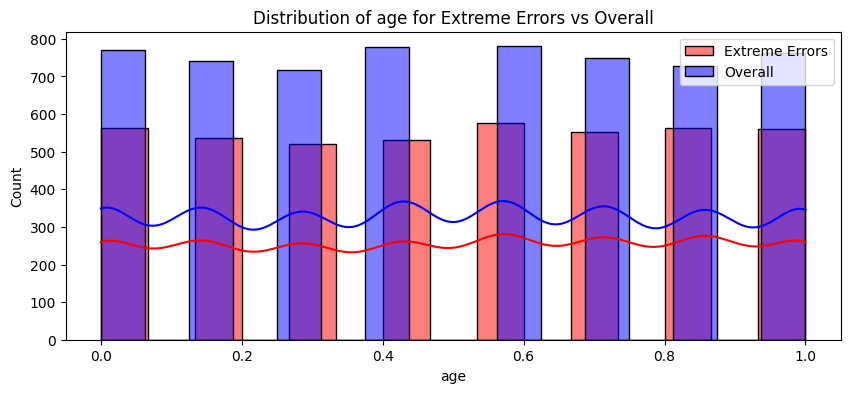

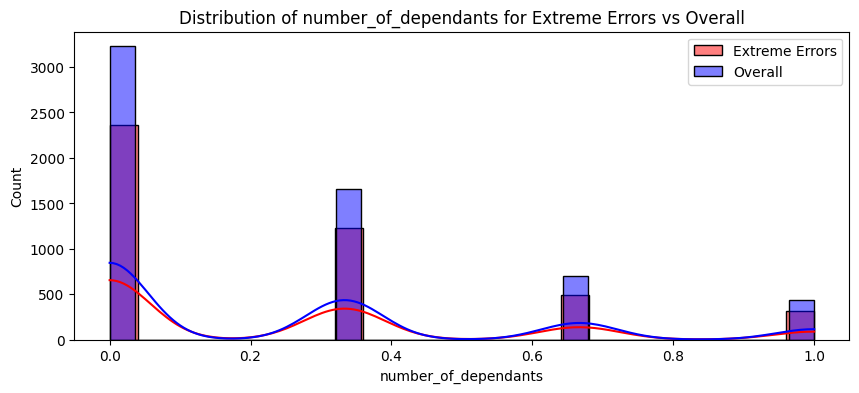

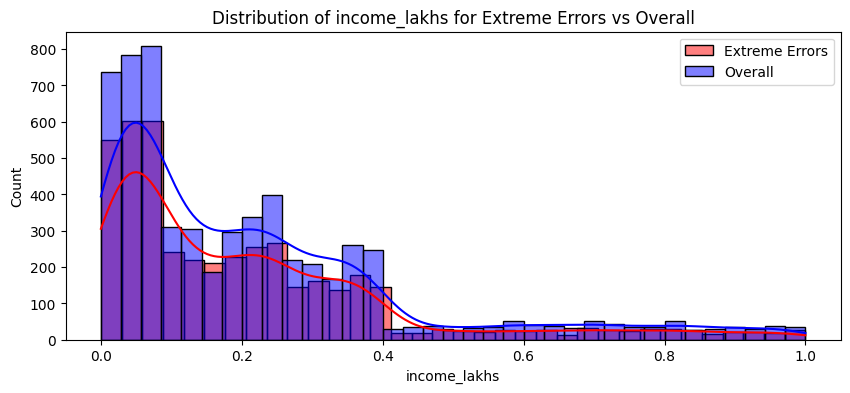

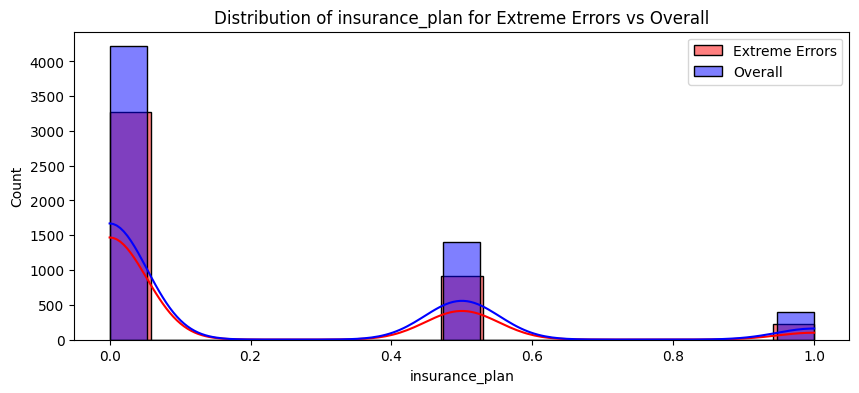

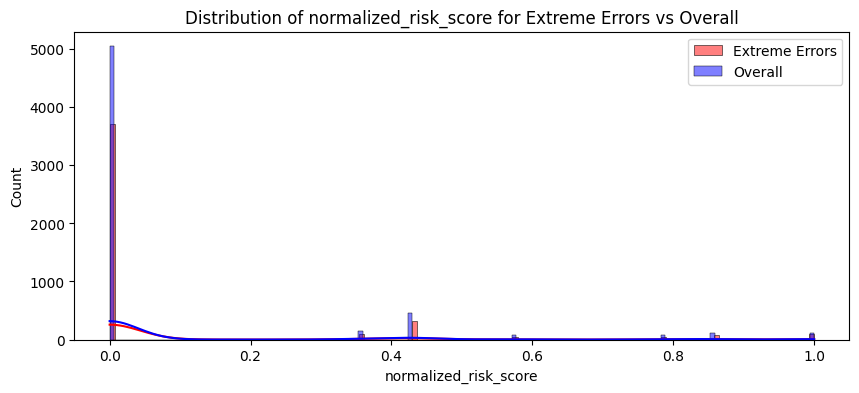

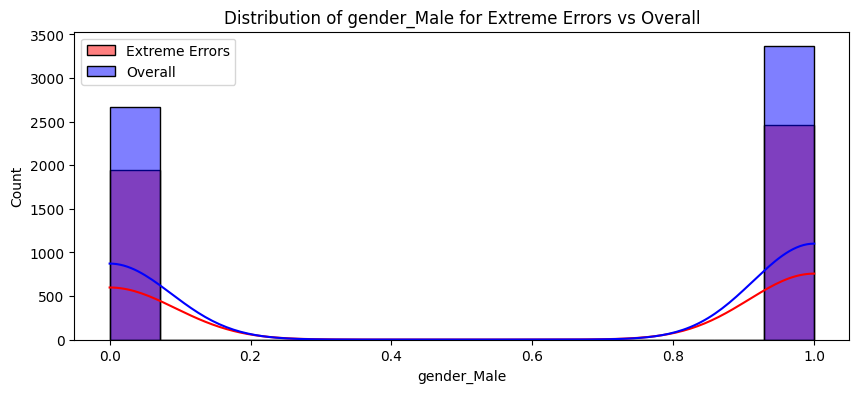

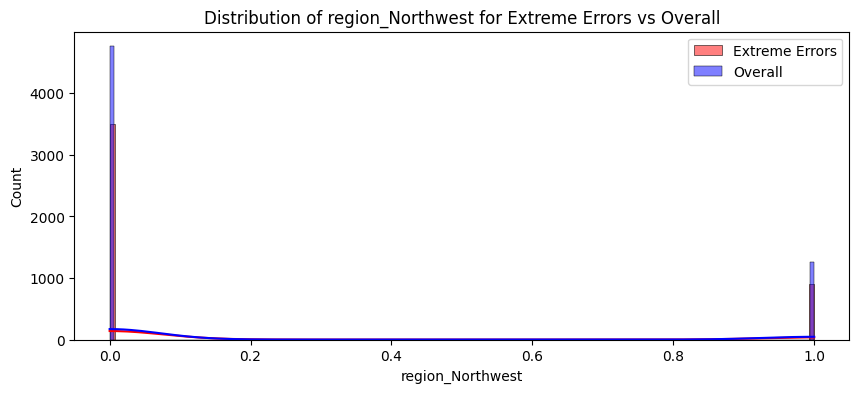

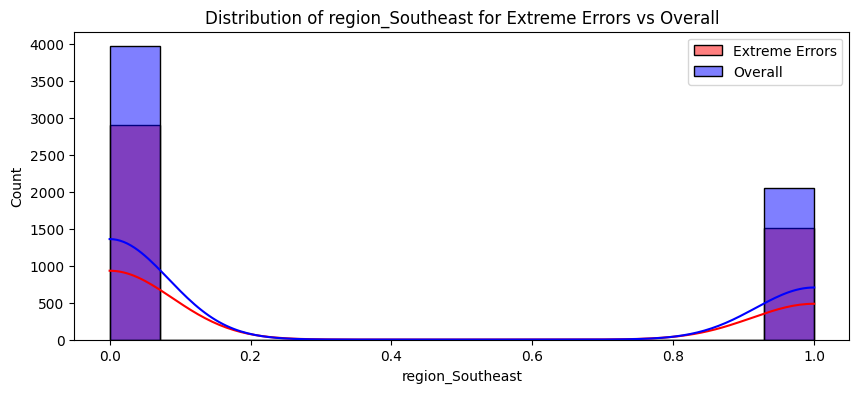

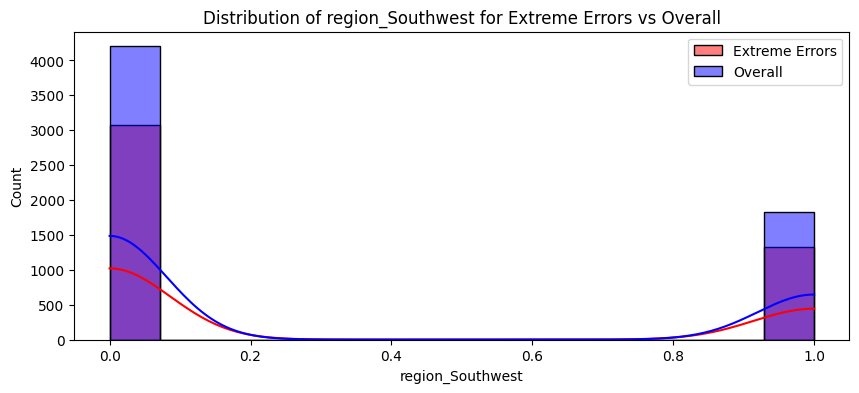

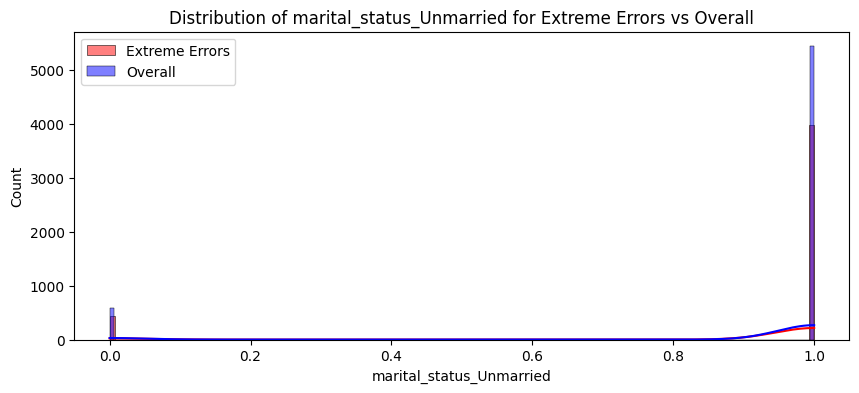

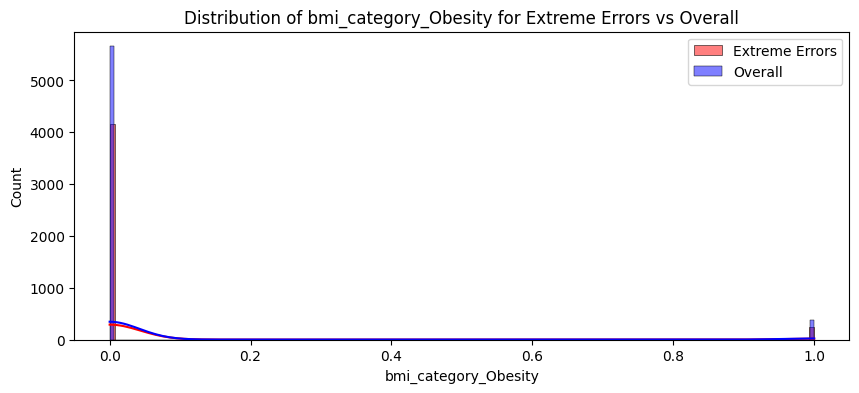

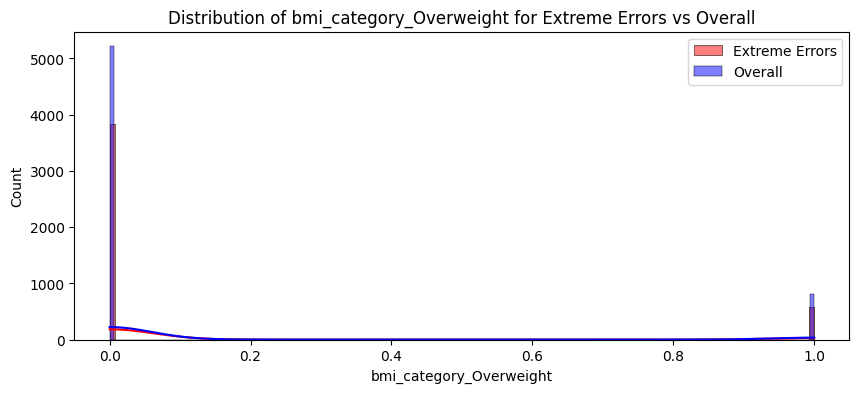

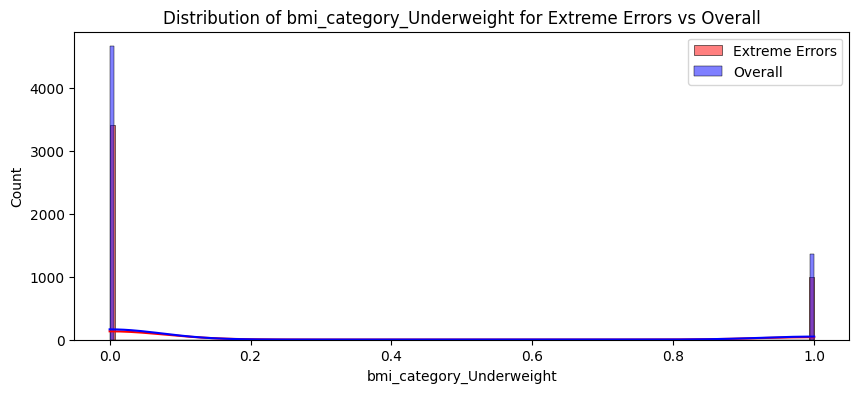

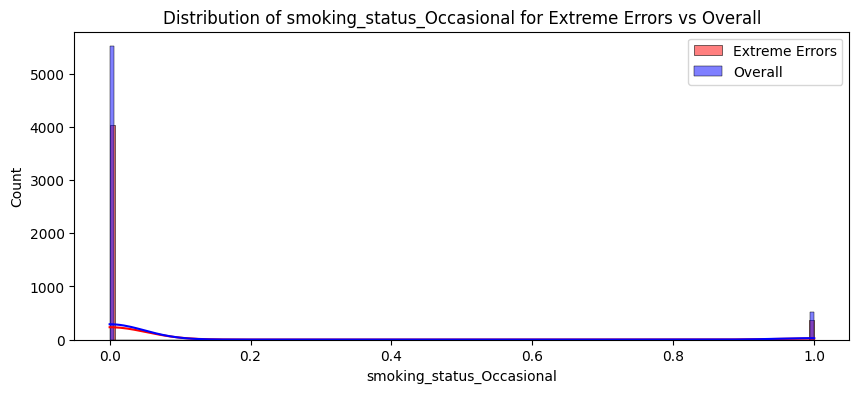

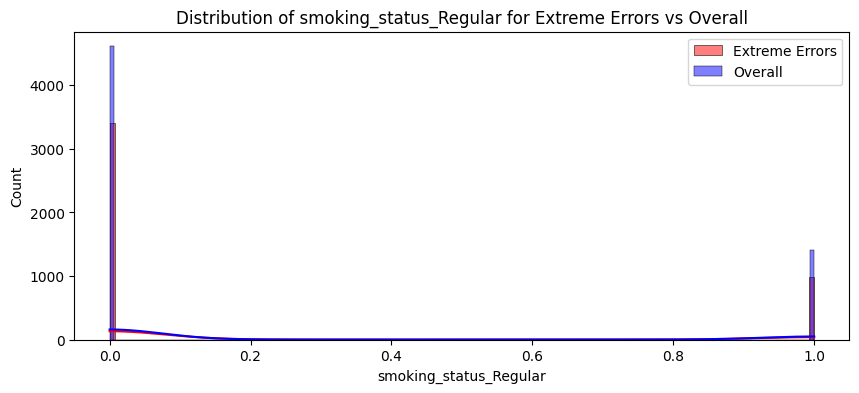

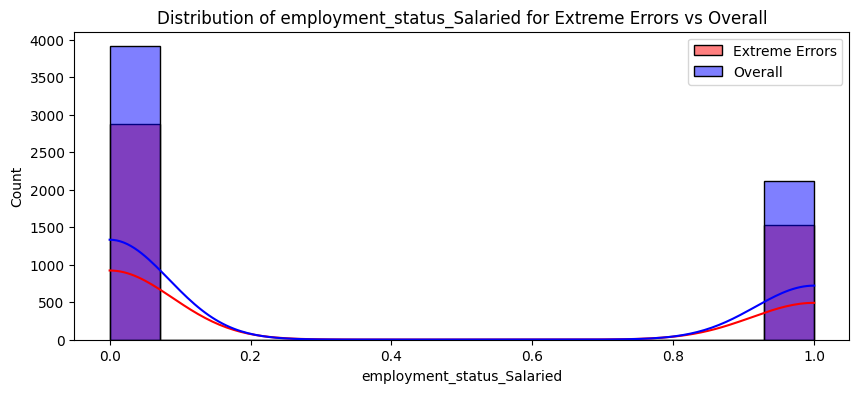

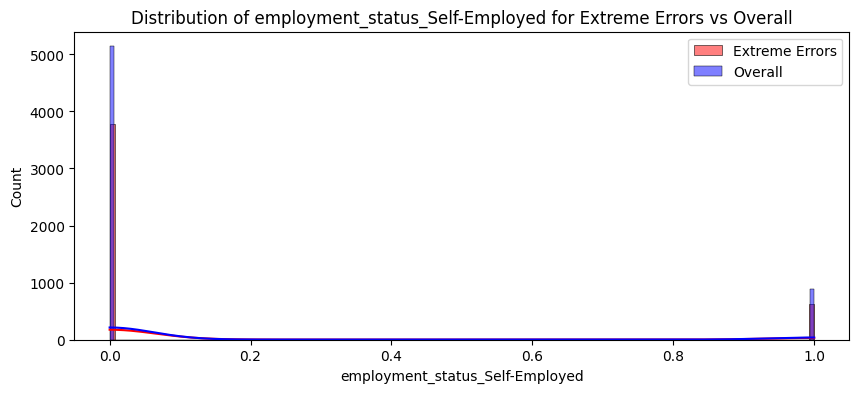

In [234]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

##### Here we can see that the Age column has some problem

#### Reverse Scaling

In [235]:
extreme_errors_df['income_level']=-1

In [236]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,20.0,0.0,-2.0,7.0,1.0
1,23.0,1.0,-2.0,15.0,1.0
2,23.0,1.0,-2.0,23.0,1.0
3,22.0,0.0,-2.0,11.0,1.0
4,21.0,1.0,-2.0,6.0,1.0


<Axes: xlabel='age', ylabel='Count'>

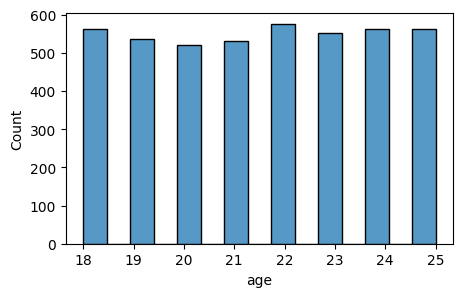

In [237]:
plt.figure(figsize=(5,3))
sns.histplot(df_reversed.age)